# Load data

In [1]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load train set
train_set = dsets.CIFAR10('../', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


# Train model with missingness

In [3]:
import torch
import torch.nn as nn
import os.path
from resnet import ResNet18
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly

In [4]:
# Select device
device = torch.device('cuda')

In [5]:
# Check for model
if os.path.isfile('cifar missingness.pt'):
    print('Loading saved model')
    model = torch.load('cifar missingness.pt').to(device)
    imputer = ImageSurrogate(model, width=32, height=32, superpixel_size=2)

else:
    # Create model
    model = nn.Sequential(
        MaskLayer2d(value=0, append=True),
        ResNet18(in_channels=4, num_classes=10)).to(device)

    # Set up surrogate wrapper (although this is not a surrogate model)
    imputer = ImageSurrogate(model, width=32, height=32, superpixel_size=2)

    # Train
    imputer.train(train_set,
                  val_set,
                  batch_size=256,
                  max_epochs=100,
                  loss_fn=nn.CrossEntropyLoss(),
                  lookback=10,
                  bar=True,
                  verbose=True)
    
    # Save model
    model.cpu()
    torch.save(model, 'cifar missingness.pt')
    model.to(device)

Loading saved model


# Train FastSHAP

In [6]:
from unet import UNet
from fastshap import FastSHAP

In [7]:
# Check for model
if os.path.isfile('cifar missingness explainer.pt'):
    print('Loading saved explainer model')
    explainer = torch.load('cifar missingness explainer.pt').to(device)
    fastshap = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))

else:
    # Set up explainer model
    explainer = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))

    # Set up datasets
    fastshap_train = DatasetInputOnly(train_set)
    fastshap_val = DatasetInputOnly(val_set)

    # Train
    fastshap.train(
        fastshap_train,
        fastshap_val,
        batch_size=128,
        num_samples=2,
        max_epochs=200,
        eff_lambda=1e-2,
        validation_samples=1,
        lookback=10,
        bar=True,
        verbose=True)
    
    # Save explainer
    explainer.cpu()
    torch.save(explainer, 'cifar missingness explainer.pt')
    explainer.to(device)

Loading saved explainer model


# Visualize results

In [8]:
import numpy as np
import matplotlib.pyplot as plt

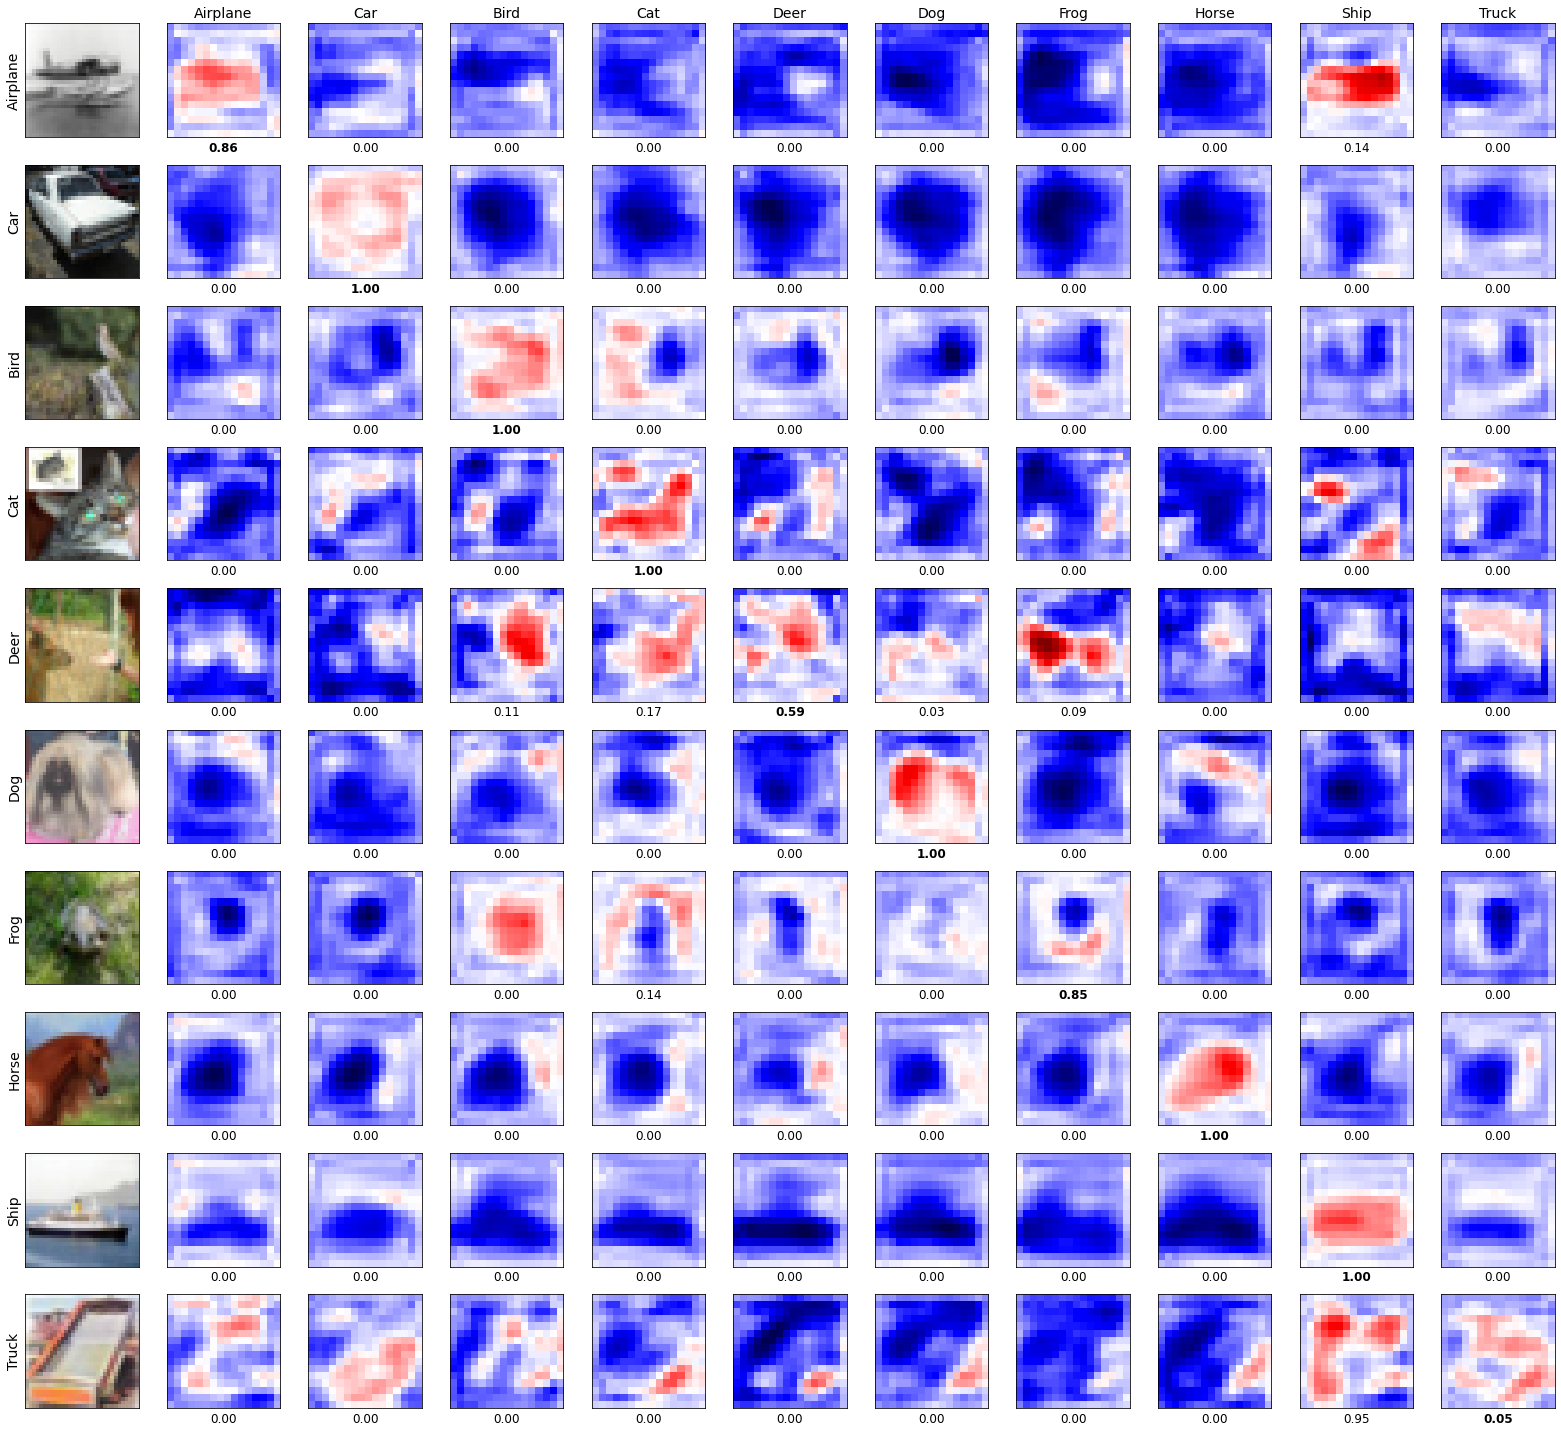

In [9]:
# Select one image from each class
dset = val_set
targets = np.array(dset.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Get explanations
values = fastshap.shap_values(x.to(device))

# Get predictions
pred = imputer(
    x.to(device),
    torch.ones(num_classes, imputer.num_players, device=device)
).softmax(dim=1).cpu().data.numpy()

fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
        else:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

plt.tight_layout()
plt.show()